In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, fftshift
import deepxde as dde
import torch

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
c:\Users\Mehdi\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:433.)
  _C._set_default_tensor_type(t)


### Function

In [2]:
# Fonction de création de l'indice de réfraction périodique
import torch

def material_index(x, y):
    period_x = 1.0
    period_y = 1.0
    amplitude = 0.5
    base_index = 2.0

    # Assurez-vous que toutes les opérations sont réalisées avec des tenseurs PyTorch
    variation = amplitude * (torch.cos(2 * torch.pi * x / period_x) * 
                             torch.cos(2 * torch.pi * y / period_y))

    # Retourner un tenseur PyTorch
    return base_index + variation

def incoherent_source(t, x, y, center_x, center_y, radius, freq_min, freq_max):
    # Calcul de la distance en utilisant PyTorch
    distance = torch.sqrt((x - center_x)**2 + (y - center_y)**2)
    
    # Appliquer la condition pour générer la source incohérente
    inside_radius = distance <= radius  # Cela crée un masque booléen pour les points à l'intérieur du rayon
    num_sources = 10  # Nombre de sources ponctuelles
    frequencies = torch.rand(num_sources) * (freq_max - freq_min) + freq_min  # Génération aléatoire des fréquences
    phases = torch.rand(num_sources) * 2 * torch.pi  # Phases aléatoires

    # Générer la source pour les points à l'intérieur du rayon
    source = torch.sum(torch.sin(2 * torch.pi * frequencies * t + phases), dim=0)
    source = source * torch.exp(-(distance / radius)**2)  # Enveloppe gaussienne

    # Appliquer le masque pour garder la source uniquement à l'intérieur du rayon
    source = torch.where(inside_radius, source, torch.tensor(0.0, device=x.device))

    return source

# Équation de Maxwell (PDE) avec des dérivées corrigées
def pde(x, y):
    # Constantes physiques
    # epsilon0 doit etre un tenseur PyTorch
    epsilon0 = torch.tensor(8.854e-12)
    mu0 = torch.tensor(4 * np.pi * 1e-7)
    
    # Indice de réfraction variable (cela doit retourner un tenseur PyTorch)
    n = material_index(x[:, 1:2], x[:, 2:3])  # Assurez-vous que `material_index` retourne un tenseur
    epsilon = n**2 * epsilon0  # `epsilon` doit être un tenseur PyTorch
    
    # Source incohérente
    source = incoherent_source(x[:, 0:1], x[:, 1:2], x[:, 2:3], 1.0, 1.0, 0.5, 1, 10)  # `source` est un tenseur PyTorch
    
    # Dérivées temporelles et spatiales
    dEx_dt = dde.grad.jacobian(y, x, i=0, j=0)  # dEx/dt
    dEy_dt = dde.grad.jacobian(y, x, i=1, j=0)  # dEy/dt
    dHz_dt = dde.grad.jacobian(y, x, i=2, j=0)  # dHz/dt
    
    dHz_dx = dde.grad.jacobian(y, x, i=2, j=1)  # dHz/dx
    dHz_dy = dde.grad.jacobian(y, x, i=2, j=2)  # dHz/dy
    
    dEx_dy = dde.grad.jacobian(y, x, i=0, j=2)  # dEx/dy
    dEy_dx = dde.grad.jacobian(y, x, i=1, j=1)  # dEy/dx
    
    # Équations de Maxwell en 2D (tous les termes doivent être en tenseurs PyTorch)
    eq1 = epsilon * dEx_dt + dHz_dy - source  # `epsilon` et `source` doivent être des tenseurs PyTorch
    eq2 = epsilon * dEy_dt - dHz_dx - source
    eq3 = mu0 * dHz_dt - (dEy_dx - dEx_dy)
    
    return [eq1, eq2, eq3]

# Condition aux limites (périodique)
def boundary_condition(x, on_boundary):
    return on_boundary

# Condition initiale (champ nul)
def initial_condition(x):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x)
    return torch.zeros((x.shape[0], 3))  # Ex, Ey, Hz initiaux nuls

### Structure definition

In [3]:
# Définition du domaine spatio-temporel
geom = dde.geometry.Rectangle([0, 0], [3, 3])  # Domaine de 10x10
timedomain = dde.geometry.TimeDomain(0, 20)  # Temps de simulation de 20 unités
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# Définir les conditions initiales pour chaque composante
ic_ex = dde.icbc.IC(
    geomtime,
    lambda x: initial_condition(x)[:, 0],  # Ex
    lambda _, on_initial: on_initial,
    component=0  # Première composante (Ex)
)

ic_ey = dde.icbc.IC(
    geomtime,
    lambda x: initial_condition(x)[:, 1],  # Ey
    lambda _, on_initial: on_initial,
    component=1  # Deuxième composante (Ey)
)

ic_hz = dde.icbc.IC(
    geomtime,
    lambda x: initial_condition(x)[:, 2],  # Hz
    lambda _, on_initial: on_initial,
    component=2  # Troisième composante (Hz)
)

In [4]:
def boundary_condition(x, on_boundary):
    return on_boundary

# Condition périodique sur l'axe x pour le composant Ex
bc_Ex = dde.icbc.PeriodicBC(geomtime, component_x=0, on_boundary=boundary_condition, component=0)

# Condition périodique sur l'axe x pour le composant Ey
bc_Ey = dde.icbc.PeriodicBC(geomtime, component_x=0, on_boundary=boundary_condition, component=1)

# Condition périodique sur l'axe x pour le composant Hz
bc_Hz = dde.icbc.PeriodicBC(geomtime, component_x=0, on_boundary=boundary_condition, component=2)

# Condition périodique sur l'axe y pour le composant Ex
bc_Ex_y = dde.icbc.PeriodicBC(geomtime, component_x=1, on_boundary=boundary_condition, component=0)

# Condition périodique sur l'axe y pour le composant Ey
bc_Ey_y = dde.icbc.PeriodicBC(geomtime, component_x=1, on_boundary=boundary_condition, component=1)

# Condition périodique sur l'axe y pour le composant Hz
bc_Hz_y = dde.icbc.PeriodicBC(geomtime, component_x=1, on_boundary=boundary_condition, component=2)



In [5]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_Ex, bc_Ey, bc_Hz, bc_Ex_y, bc_Ey_y, bc_Hz_y, ic_ex, ic_ey, ic_hz],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
)

### Neural network / model

In [6]:
# Définition du réseau neuronal
layer_size =  [3] + [128] * 8 + [3]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# Définition du modèle
model = dde.Model(data, net)


In [7]:
def mse(y_true, y_pred):
    if y_true is None or y_pred is None:
        print("y_true or y_pred is None")
        return float('inf')
    return torch.mean((y_true - y_pred)**2)

def l2_relative_error(y_true, y_pred):
    norm_true = np.linalg.norm(y_true)
    if norm_true < 1e-8:  # Vous pouvez ajuster ce seuil
        return np.linalg.norm(y_true - y_pred)
    return np.linalg.norm(y_true - y_pred) / norm_true

model.compile("adam", lr=0.001, metrics=[mse])

Compiling model...
'compile' took 3.059687 s



In [8]:
test_data = data.test()
print("Test data shape:", [t.shape if t is not None else None for t in test_data])

Test data shape: [(2700, 3), None, None]


In [9]:
losshistory, train_state = model.train(epochs=100000)

Training model...

y_true or y_pred is None
Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric   
0         [6.02e+02, 6.01e+02, 4.36e-03, 8.43e-02, 2.67e-02, 7.63e-03, 7.87e-03, 3.61e-02, 2.31e-03, 1.73e-01, 5.05e-02, 9.16e-02]    [3.19e+02, 3.19e+02, 4.36e-03, 8.43e-02, 2.67e-02, 7.63e-03, 7.87e-03, 3.61e-02, 2.31e-03, 1.73e-01, 5.05e-02, 9.16e-02]    [inf]         
y_true or y_pred is None
1000      [5.20e+02, 5.20e+02, 3.00e-07, 1.19e-06, 6.79e-07, 7.06e-07, 3.99e-07, 3.83e-07, 8.65e-06, 4.52e-06, 2.90e-05, 1.88e-05]    [3.98e+02, 3.98e+02, 3.00e-07, 1.19e-06, 6.79e-07, 7.06e-07, 3.99e-07, 3.83e-07, 8.65e-06, 4.52e-06, 2.90e-05, 1.88e-05]    [inf]         
y_true or y_pred is None
2000      [2.30e+02, 2.30e+02, 5.02e-08, 2.02e-07, 2.00e-08, 1.07e-08, 2.80e-08, 2.01e-

KeyboardInterrupt: 

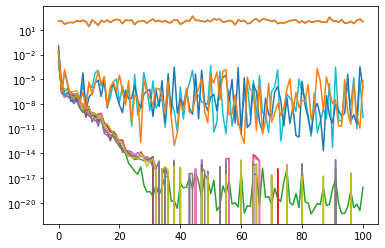

In [ ]:
#display thte loss history 
import matplotlib.pyplot as plt

plt.figure()
_ = plt.semilogy(losshistory.loss_train, label="Train loss")

### Prediction 

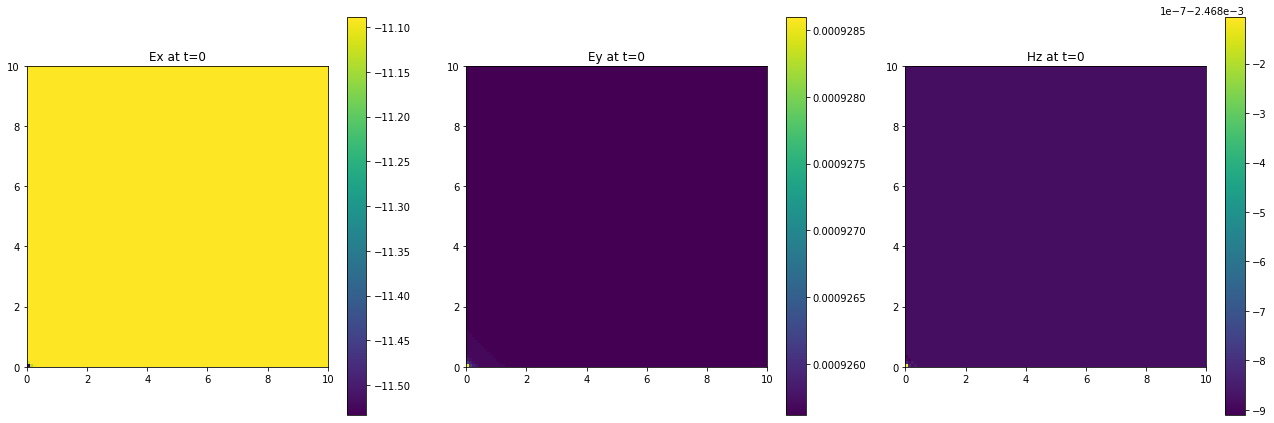

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_final_em_field(model, t_final=20, num_points=100):
    # Créer une grille de points
    x = np.linspace(0, 10, num_points)
    y = np.linspace(0, 10, num_points)
    X, Y = np.meshgrid(x, y)
    
    # Préparer les données d'entrée pour le modèle
    xy = np.vstack((X.flatten(), Y.flatten())).T
    t_array = np.full((xy.shape[0], 1), t_final)
    X_pred = np.hstack((t_array, xy))
    
    
    # Faire la prédiction
    output = model.predict(X_pred)
    
    # Extraire Ex, Ey, Hz
    Ex = output[:, 0].reshape(X.shape)
    Ey = output[:, 1].reshape(X.shape)
    Hz = output[:, 2].reshape(X.shape)
    
    # Visualiser les résultats
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Ex
    im1 = axes[0].imshow(np.log(Ex), extent=[0, 10, 0, 10], origin='lower', cmap='viridis')
    axes[0].set_title(f'Ex at t={t_final}')
    plt.colorbar(im1, ax=axes[0])
    #display in log scale

    
    # Ey
    im2 = axes[1].imshow(Ey, extent=[0, 10, 0, 10], origin='lower', cmap='viridis')
    axes[1].set_title(f'Ey at t={t_final}')
    plt.colorbar(im2, ax=axes[1])
    
    # Hz
    im3 = axes[2].imshow(Hz, extent=[0, 10, 0, 10], origin='lower', cmap='viridis')
    axes[2].set_title(f'Hz at t={t_final}')
    plt.colorbar(im3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

# Utilisation
visualize_final_em_field(model, t_final=0)

### Plot data 

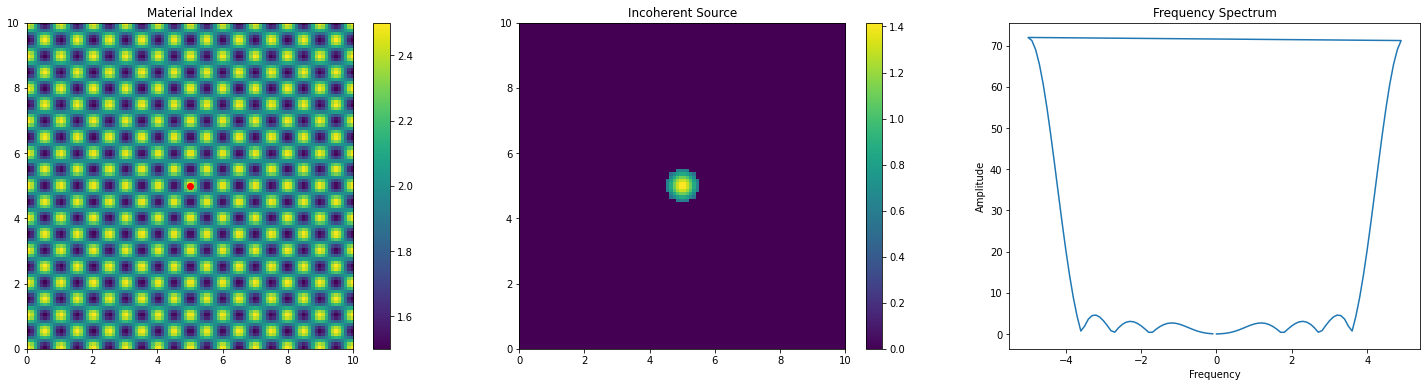

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def visualize_sources(t, x, y, center_x, center_y, radius, freq_min, freq_max):
    # Visualisation de la structure périodique avec la source
    x = np.linspace(0, 10, 100)
    y = np.linspace(0, 10, 100)
    X, Y = np.meshgrid(x, y)

    # Convert to tensor
    X = torch.tensor(X).to('cuda')
    Y = torch.tensor(Y).to('cuda')

    # Calcul de l'indice de réfraction
    n = material_index(X, Y)

    # Move tensors to CPU and convert to NumPy arrays
    X = X.cpu().detach().numpy()
    Y = Y.cpu().detach().numpy()
    n = n.cpu().detach().numpy()

    

    # Utilisation de la source incohérente
    X_pred = torch.tensor(np.c_[X.ravel(), Y.ravel()]).to('cuda')
    source = incoherent_source(t, X_pred[:, 0], X_pred[:, 1], center_x, center_y, radius, freq_min, freq_max)

    # Move source tensor to CPU and convert to NumPy array
    source = source.cpu().detach().numpy()

    # Visualiser les résultats
    fig, axes = plt.subplots(1, 3, figsize=(25, 6))
    #display the sources result 
    im1 = axes[0].imshow(n, extent=[0, 10, 0, 10], origin='lower', cmap='viridis')
    #add scatter with position of the source on the material index
    axes[0].scatter(center_x, center_y, color='red', label='Source Center')
    axes[0].set_title('Material Index')
    plt.colorbar(im1, ax=axes[0])

    # Source incohérente
    source = source.reshape(X.shape)
    im2 = axes[1].imshow(source, extent=[0, 10, 0, 10], origin='lower', cmap='viridis')
    axes[1].set_title('Incoherent Source')
    plt.colorbar(im2, ax=axes[1])

    # Display the frequency spectrum of the source
    freqs = np.fft.fftfreq(100, d=10/100)
    source_fft = np.fft.fft2(source)
    source_fft = np.abs(np.fft.fftshift(source_fft))
    im3 = axes[2].plot(freqs, source_fft[50, :])
    axes[2].set_title('Frequency Spectrum')
    axes[2].set_xlabel('Frequency')
    axes[2].set_ylabel('Amplitude')

# Utilisation
visualize_sources(t=0, x=0, y=0, center_x=5.0, center_y=5.0, radius=0.5, freq_min=1, freq_max=3)

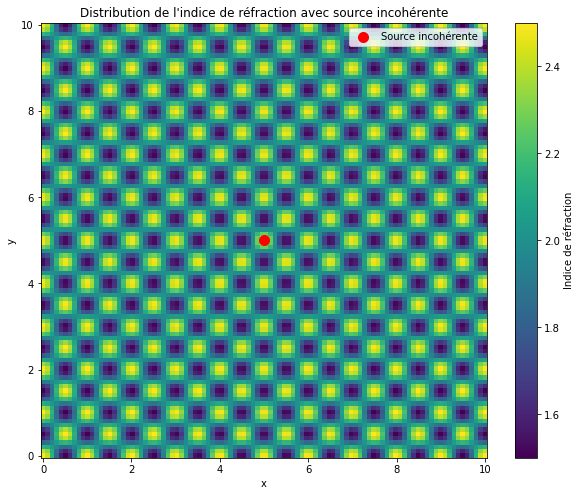

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Visualisation de la structure périodique avec la source
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)

# Convert to tensor
X = torch.tensor(X).to('cuda')
Y = torch.tensor(Y).to('cuda')

# Calcul de l'indice de réfraction
n = material_index(X, Y)

# Move tensors to CPU and convert to NumPy arrays
X = X.cpu().detach().numpy()
Y = Y.cpu().detach().numpy()
n = n.cpu().detach().numpy()

plt.figure(figsize=(10, 8))
plt.pcolormesh(X, Y, n, shading='auto')
plt.colorbar(label='Indice de réfraction')
plt.title('Distribution de l\'indice de réfraction avec source incohérente')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(5, 5, color='red', s=100, label='Source incohérente')
plt.legend()
plt.show()